In [1]:

import pdb
import os
import traceback
import numpy as np
import jax
from jax import numpy as jnp
import optax
import wandb
import equinox as eqx
from typing import Optional, Callable
import librosa

from common_dl_utils.config_creation import Config
import common_jax_utils as cju

wandb.login()

key = jax.random.PRNGKey(12398)
key_gen = cju.key_generator(key)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: abdtab (abdtab-tue). Use `wandb login --relogin` to force relogin


In [2]:
def load_audio_file(file_path, sr=16000, save_npy=True):
    """
    Load an audio file and return it as a normalized numpy array.
    Optionally save as .npy file.
    """
    # Load the audio file
    audio, _ = librosa.load(file_path, sr=sr)
    
    # Convert to numpy array and normalize to [-1, 1] range
    audio = np.array(audio, dtype=np.float32)
    audio = audio / np.max(np.abs(audio))

    if save_npy:
        # Create npy filename from original audio filename
        npy_path = os.path.splitext(file_path)[0] + '.npy'
        np.save(npy_path, audio)
        return audio, len(audio), npy_path
   
    return audio, len(audio), None

In [3]:
# First set up the config properly
config = Config()

# Model architecture configuration
config.architecture = './model_components'  # module containing model classes
config.model_type = 'inr_modules.CombinedINR'

# Model configuration
config.model_config = Config()
config.model_config.in_size = 1 # Time dimension input
config.model_config.out_size = 1  # Audio amplitude output
config.model_config.terms = [
    ('inr_modules.MLPINR.from_config',{
        'hidden_size': 256,
        'num_layers': 5,
        'layer_type': 'inr_layers.SirenLayer',
        'num_splits': 1,
        'use_complex': False,
        'activation_kwargs': {'w0': 30.},
        'initialization_scheme':'initialization_schemes.siren_scheme',
        'positional_encoding_layer': ('inr_layers.ClassicalPositionalEncoding.from_config', {'num_frequencies': 10}),
    }),
    # ('inr_modules.MLPINR.from_config',{
    #     'hidden_size': 1024,
    #     'num_layers': 2,
    #     'num_splits': 1,
    #     'layer_type': 'inr_layers.GaussianINRLayer',
    #     'use_complex': False,
    #     'activation_kwargs': {'inverse_scale': 1},
    # })
    # ('inr_modules.MLPINR.from_config',{
    #     'hidden_size': 256,
    #     'num_layers': 5,
    #     'layer_type': 'inr_layers.FinerLayer',
    #     'num_splits': 1,
    #     'use_complex': False,
    #     'activation_kwargs': {'w0': 30},
    #     'initialization_scheme':'initialization_schemes.finer_scheme',
    #     'initialization_scheme_kwargs': {'bias_k': 10,'scale_factor': 10}
    #     # 'initialization_scheme_k' : {'k': 20}
    #     #'positional_encoding_layer': ('inr_layers.ClassicalPositionalEncoding.from_config', {'num_frequencies': 10}),
    # })
]

# Training configuration
config.trainer_module = './inr_utils'  # module containing training code
config.trainer_type = 'training.train_inr'

# Loss function configuration
config.loss_evaluator = config.loss_function = 'losses.SoundLossEvaluator'
config.loss_evaluator_config = config.loss_function_config = {
    'time_domain_weight': 1.0,
    'frequency_domain_weight': 0.1
}

# Optimizer configuration
config.optimizer = 'adam'  # will use optax.adam
config.optimizer_config = {
    'learning_rate': 1e-3
}

# Load and save the audio file
audio_path = './example_data/data_gt_bach.wav'  # Make sure this path exists
audio_data, fragment_length, npy_path = load_audio_file(audio_path)

# Sampler configuration
config.sampler = ('sampling.SoundSampler', {
    'window_size': 1024,
    'batch_size': 32,
    'fragment_length': fragment_length,  # Will be set after loading audio
    'sound_fragment': npy_path
})


# Metric collector configuration
config.metric_collector_config = {
    'metrics': [
        ('metrics.AudioMetricsOnGrid', {
            'target_audio': audio_data,
            'grid_size': fragment_length,
            'batch_size': 1024,  # This will be automatically adjusted if needed
            'sr': 16000,
            'frequency': 'every_n_batches'
        })
    ],
    'batch_frequency': 100,
    'epoch_frequency': 1
}
# Callback configuration for logging
config.after_step_callback = 'callbacks.ComposedCallback'  # This line was missing
config.after_step_callback_config = {
    'callbacks': [
        ('callbacks.print_loss', {'after_every': 10}),
        'callbacks.report_loss',
        'callbacks.raise_error_on_nan',
        ('callbacks.AudioMetricsCallback', {
            'metric_collector': ('metrics.MetricCollector', config.metric_collector_config),
            'print_metrics': True,
            'print_frequency': 100
        })
    ],
    'use_wandb': True,  # This was missing
    'show_logs': False
}

# # Callback configuration for logging
# config.after_step_callback = 'callbacks.ComposedCallback'
# config.after_step_callback_config = {
#     'callbacks': [
#         ('callbacks.print_loss', {'after_every': 10}),
#         'callbacks.report_loss',
#         'callbacks.raise_error_on_nan'
#     ],
#     'show_logs': False
# }



config.after_training_callback = None
config.optimizer_state = None
config.steps = 40000
config.use_wandb = True


In [4]:
try:
    inr = cju.run_utils.get_model_from_config_and_key(
        prng_key=next(key_gen),
        config=config,
        model_sub_config_name_base='model',
        add_model_module_to_architecture_default_module=False,
    )
except Exception as e:
    traceback.print_exc()
    print(e)
    print('\n')
    pdb.post_mortem()


In [5]:
# Then get the experiment
experiment = cju.run_utils.get_experiment_from_config_and_key(
    prng_key=next(key_gen),
    config=config,
    model_kwarg_in_trainer='inr',
    model_sub_config_name_base='model',
    trainer_default_module_key='trainer_module',
    additional_trainer_default_modules=[optax],
    add_model_module_to_architecture_default_module=False,
    initialize=False
)


Audio Metrics at step 0:
Loss at step 10 is 30610.548828125.
Loss at step 20 is 19331.73828125.
Loss at step 30 is 11263.666015625.
Loss at step 40 is 7340.11083984375.
Loss at step 50 is 6620.32568359375.
Loss at step 60 is 3683.586669921875.
Loss at step 70 is 3922.199951171875.
Loss at step 80 is 2744.771240234375.
Loss at step 90 is 2827.145263671875.
Loss at step 100 is 2594.59521484375.

Audio Metrics at step 100:
Loss at step 110 is 1873.4334716796875.
Loss at step 120 is 1933.727783203125.
Loss at step 130 is 1942.9052734375.
Loss at step 140 is 1578.4276123046875.
Loss at step 150 is 1960.3394775390625.
Loss at step 160 is 1416.6668701171875.
Loss at step 170 is 1639.3818359375.
Loss at step 180 is 1826.7247314453125.
Loss at step 190 is 1431.956298828125.
Loss at step 200 is 1541.4476318359375.

Audio Metrics at step 200:
Loss at step 210 is 1228.98095703125.
Loss at step 220 is 1540.6260986328125.
Loss at step 230 is 1684.2099609375.
Loss at step 240 is 1602.761962890625.
L

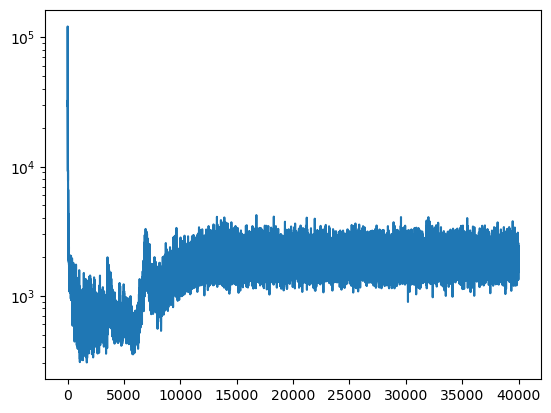

audio_magnitude_error,▄▁▃▄▂▆▅▅▆▇▇█▇▇▇▇██▇██▇█▇█▆▇█▇▇▇▇▇▇▇▇██▇█
audio_mse,▇▄▆▆▄▃▃▃▂▁▇██▆▅▅▅▅▆▆▅▅▅▅▅▅▅▅▅▅▆▅▅▅▅▆▅▅▆▅
audio_psnr,▄▄▆▆█▁▃▄▄▄▄▅▄▄▄▄▄▄▄▄▅▄▄▄▄▄▄▅▄▄▄▅▄▄▄▃▄▃▄▄
audio_snr,▄▅▄▄▄▅▄▅▆█▃▁▂▃▄▅▄▄▄▅▅▅▅▅▅▅▅▅▄▅▄▄▅▄▄▅▅▅▄▅
audio_spectral_convergence,▃▃▁▂▃▁▁▂▅▅██████████████████████████████
batch_within_epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇█
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,▁▁▁▁▁▃▄▃▄▅▅▄▄▇▅▅▆▄▅▇▄█▄▇▅▃▄▄▆▅▆▆▆▄▅▄▅▇▄▇
audio_magnitude_error,1.23085
audio_mse,0.03025
audio_psnr,15.19253


In [6]:
# Run the experiment with wandb logging
try: 
        
    with wandb.init(
        project='inr-audio',
        config={
            'window_size': config.sampler[1]['window_size'],
            'batch_size': config.sampler[1]['batch_size'],
            'learning_rate': config.optimizer_config['learning_rate'],
            'steps': config.steps,
            'audio_path': config.sampler[1]['sound_fragment']
        }
    ) as run:
        results = experiment.initialize()
        
except Exception as e:
    traceback.print_exc()
    print(e)
    print('\n')
    pdb.post_mortem()